In [1]:
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import numpy as np
import os
import copy
import unicodedata
import string
import re
import json

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

class RewardNet(nn.Module):
    def __init__(
        self, state_dim, output_mod=None):
        super().__init__()
        self.reward = nn.Sequential(
            nn.Linear(state_dim, state_dim), nn.ReLU(),
            nn.Linear(state_dim, state_dim), nn.ReLU(),
            nn.Linear(state_dim, 1)
        )
        self.pref = nn.Linear(2, 1)
        self.apply(weight_init)

    def forward(self, state1, state2):
        r1 = self.reward(state1)
        r2 = self.reward(state2)
        comp = torch.squeeze(torch.stack([r1,r2], dim=1))
        pref = self.pref(comp)
        return r1, r2, pref

In [25]:
state_dim = 18

reward_net = RewardNet(state_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reward_net.to(device)

RewardNet(
  (reward): Sequential(
    (0): Linear(in_features=18, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=1, bias=True)
  )
  (pref): Linear(in_features=2, out_features=1, bias=True)
)

In [26]:
import csv
with open('data/train_rewards500.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1 = []
    states2 = []
    prefs = []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)

[1,     1] loss: 0.69445956
[2,     1] loss: 0.67478549
[3,     1] loss: 0.65744358
[4,     1] loss: 0.63852173
[5,     1] loss: 0.61659920
[6,     1] loss: 0.59031898
[7,     1] loss: 0.55884409
[8,     1] loss: 0.52467579
[9,     1] loss: 0.49055538
[10,     1] loss: 0.45885351
[11,     1] loss: 0.43160295
[12,     1] loss: 0.40957212
[13,     1] loss: 0.39132467
[14,     1] loss: 0.37490264
[15,     1] loss: 0.35903946
[16,     1] loss: 0.34357610
[17,     1] loss: 0.32860270
[18,     1] loss: 0.31386596
[19,     1] loss: 0.29923943
[20,     1] loss: 0.28471333
[21,     1] loss: 0.27027339
[22,     1] loss: 0.25574464
[23,     1] loss: 0.24117868
[24,     1] loss: 0.22645532
[25,     1] loss: 0.21169171
[26,     1] loss: 0.19721271
[27,     1] loss: 0.18302670
[28,     1] loss: 0.16919193
[29,     1] loss: 0.15586205
[30,     1] loss: 0.14307502
[31,     1] loss: 0.13091090
[32,     1] loss: 0.11944825
[33,     1] loss: 0.10868520
[34,     1] loss: 0.09864108
[35,     1] loss: 0.089

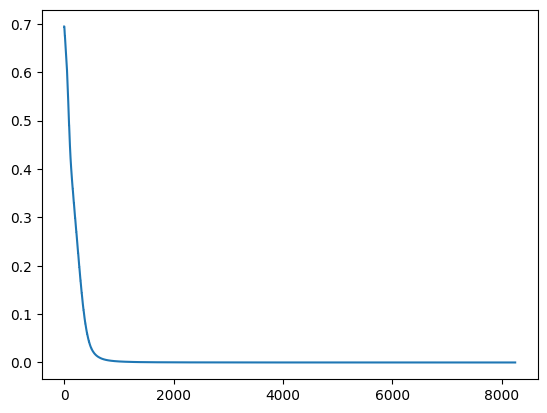

In [27]:
num_epochs = 750
batch_size = 50

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(reward_net.parameters()), lr=0.001)

losses = []

idxs = np.array(range(len(states1)))
num_batches = len(idxs) // batch_size

# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
   
        t_states1 = torch.Tensor(states1).float().to(device)
        t_states2 = torch.Tensor(states2).float().to(device)
        t_prefs = torch.Tensor(prefs).float().to(device).unsqueeze(1)

        pred_r1s, pred_r2s, pred_prefs = reward_net(t_states1, t_states2)
        loss = criterion(pred_prefs, t_prefs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

torch.save(reward_net, 'reward_network.pt')
print('Finished Training')
plt.plot(losses)
plt.savefig('losses.png')

In [28]:
reward_net = torch.load('reward_network.pt')
reward_net.eval()

import csv
with open('data/test_rewards.csv') as file_obj:
    reader_obj = csv.reader(file_obj)

    states1 = []
    states2 = []
    prefs = []
    for row in reader_obj:
        states1.append(row[0:18])
        states2.append(row[19:37])
        prefs.append(row[38])
    states1 = np.array(states1,dtype=int)
    states2 = np.array(states2,dtype=int)
    prefs = np.array(prefs,dtype=int)

num_correct = 0.0
for i in range(len(states1)):
    state1 = torch.Tensor(states1[i]).to(device)
    state2 = torch.Tensor(states2[i]).to(device)
    pred_r1, pred_r2, pred_pref = reward_net(state1, state2)
    pred_r1 = torch.sigmoid(pred_r1)
    pred_r2 = torch.sigmoid(pred_r2)
    pred_pref = torch.sigmoid(pred_pref).cpu().detach().numpy()[0]
    if pred_pref > 0.5 and prefs[i] == 1:
        num_correct+=1
    elif pred_pref <= 0.5 and prefs[i] == 0:
        num_correct+=1

accuracy = num_correct / len(states1)
print("Percent correct: %f " % accuracy)

Percent correct: 1.000000 


In [ ]:
print(pred_r1)
print(pred_r2)
print(pred_pref)

In [ ]:
best_mushroom = torch.Tensor(np.array([1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0])).to(device)
pred_r1, pred_r2, pred_pref = reward_net(best_mushroom,best_mushroom)
print(torch.sigmoid(pred_r1))
print(torch.sigmoid(pred_r2))
print(torch.sigmoid(pred_pref))